<a href="https://colab.research.google.com/github/paulstoy/FluxTowers/blob/main/TowerEnvironment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TowerEnvironment.ipynb

Use this file to perform analyses and create all figures except for the soil texture triangle (written in R) for 'The climate, soils, and distance between eddy covariance towers'.

First, load libraries, and import data from [github](https://github.com/paulstoy/FluxTowers), noting the [ReadMe](https://github.com/paulstoy/FluxTowers/blob/main/README.md) file.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import geopandas as gpd
import seaborn as sns

a = pd.read_csv('https://raw.githubusercontent.com/paulstoy/FluxTowers/main/Towers.csv')
r = pd.read_csv('https://raw.githubusercontent.com/paulstoy/FluxTowers/main/RandomPoints.csv')
rdepth = pd.read_csv('https://raw.githubusercontent.com/paulstoy/FluxTowers/main/RandomSoilDepth.csv',header=None)
tdepth = pd.read_csv('https://raw.githubusercontent.com/paulstoy/FluxTowers/main/TowerSoilDepth.csv')

Quantify the distance between all towers. This takes awhile, 'distm' from the 'geosphere' package in R is much faster. Skip this chunk if you would rather import its output available on github, which can be loaded using the chunk below this one.

In [ ]:
import geopy.distance

R,C=a.shape

m = np.empty((R,R))

for i in range(0,R):
  print(i)
  for j in range(0,R):
    m[i,j] = geopy.distance.geodesic((a.Lat[i], a.Long[i]),(a.Lat[j], a.Long[j])).km

#trick python into thinking the eigenvalues are impossibly large
m[m==0] = 1e10

#calculate the minimum distance to another tower for each tower site
x = np.min(m,axis=0)

#create a pandas dataframe with rows and columns labeled
m_pd = pd.DataFrame(m, columns=a["Site ID"], index=a["Site ID"])

Alternately, load the distance matrix directly from github as a CSV UTF-8 and extract the list of shortest distances, 'x'.

In [ ]:
m_pd = pd.read_csv('https://raw.githubusercontent.com/paulstoy/FluxTowers/main/DistanceMatrix.csv')
mtemp = m_pd
del mtemp['Site ID']
m = np.array(mtemp)
del mtemp
m[m==0] = 1e10
x = np.min(m_pd,axis=0)

#Figure 1:
A map of tower locations, colored by distance to nearest tower

<ipython-input-3-ec9012f6b3ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["km"] = x.tolist()
<ipython-input-3-ec9012f6b3ac>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


<Axes: >

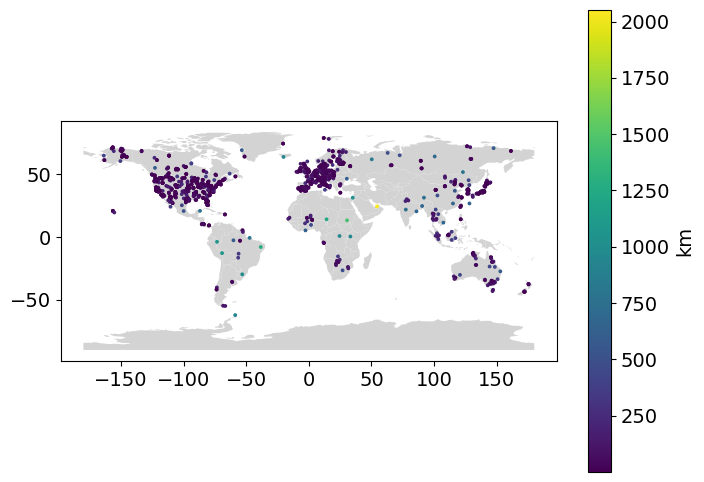

In [ ]:
d = a[["Lat", "Long"]]
#d["Dist (km)"] = np.log(x).tolist()
d["km"] = x.tolist()

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(8,6))
countries.plot(color="lightgrey",ax=ax)
d.plot(x="Long", y="Lat", kind="scatter",s=3,xlabel="",ylabel="", c="km",colormap="viridis", ax=ax)

#Figure S1:
The cumulative percentage of ranked distances.

[625. 626.]
[1063.]


Text(0.5, 0, 'Percentage of sites')

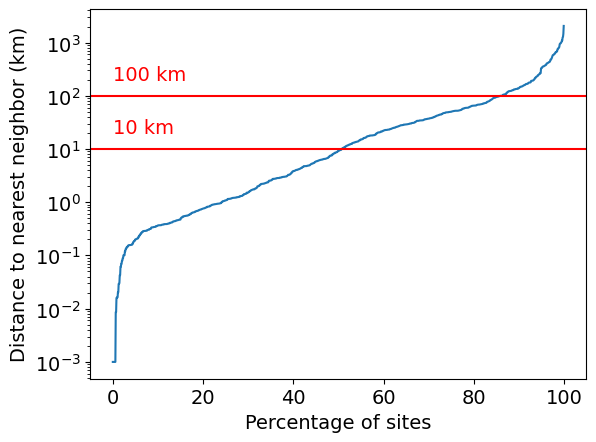

In [ ]:
x[x < 1e-3] = 1e-3 #set sites with < 1 m distance to 1 m; co-located towers would be difficult to position < 1 m apart due to flow distortion
xax = np.arange(0,len(x))/len(x)*100
sortx = np.sort(x)
print(xax[(sortx>9.9) & (sortx < 10.1)]*1233/100)
print(xax[(sortx>99.9) & (sortx < 100.1)]*1233/100)

plt.semilogy(xax,np.sort(x))
plt.axhline(10,xmin=0, xmax=100,color='r')
plt.axhline(100,xmin=0, xmax=100,color='r')
plt.text(0,20,'10 km',color='r')
plt.text(0,200,'100 km',color='r')
plt.ylabel('Distance to nearest neighbor (km)')
plt.xlabel('Percentage of sites')



#Figure S2:
a plot of tower temperature and precipitation against a kernel density estimate of global temperature and precipitation

Text(0, 0.5, 'MAP (mm)')

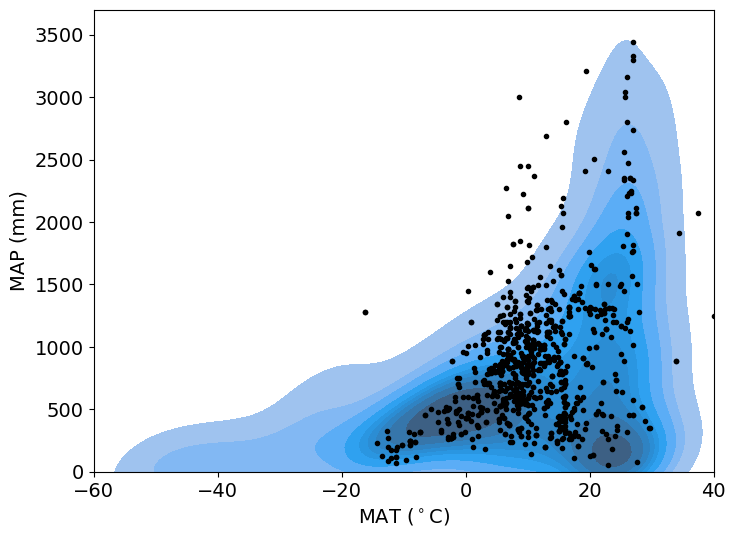

In [ ]:
PTglobal = r[["MAT_ds", "MAP_ds"]]

fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(data=PTglobal, x="MAT_ds", y="MAP_ds", fill=True,ax=ax)
plt.plot(a.MAT,a.MAP,'.',color='k')
plt.xlim([-60,40])
plt.ylim([0,3700])
plt.xlabel("MAT ($^\circ$C)")
plt.ylabel("MAP (mm)")

#Figure 2:
KDEs of climate characteristics compared to dataset pixels that contain eddy covariance towers

Text(310000, 9e-06, '(c)')

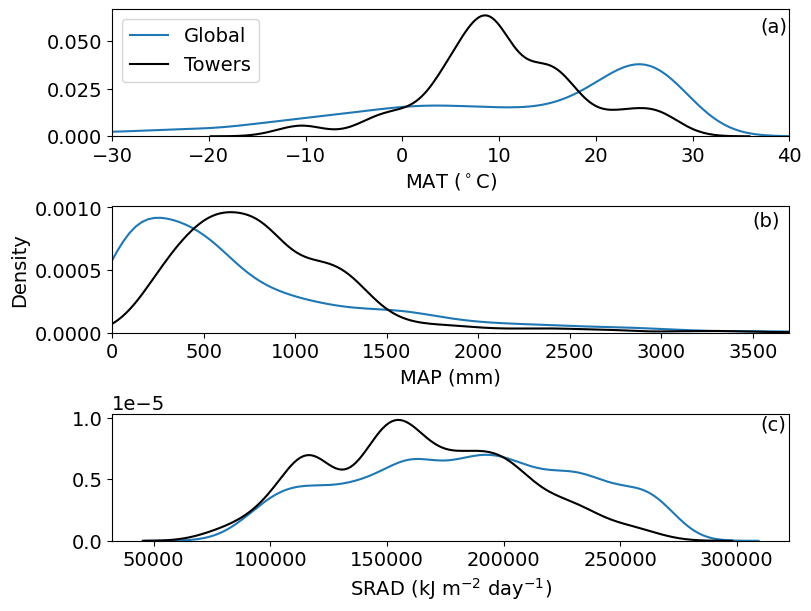

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8,6),layout='constrained')
sns.kdeplot(ax=axs[0],data=r,x='MAT_ds',label='Global')
sns.kdeplot(ax=axs[0],data=a,x='MAT_ds',color='k',label='Towers')
axs[0].set(xlabel="MAT ($^\circ$C)", ylabel="",xlim=([-30,40]))
axs[0].legend()
axs[0].text(37,0.055,"(a)")

sns.kdeplot(ax=axs[1],data=r,x='MAP_ds')
sns.kdeplot(ax=axs[1],data=a,x='MAP_ds',color='k')
axs[1].set(xlabel="MAP (mm)", ylabel="Density",xlim=([0,3700]))
axs[1].text(3500,0.00085,"(b)")

sns.kdeplot(ax=axs[2],data=r,x='SRAD_ds')
sns.kdeplot(ax=axs[2],data=a,x='SRAD_ds',color='k')
axs[2].set(xlabel="SRAD (kJ m$^{-2}$ day$^{-1}$)", ylabel="")
axs[2].text(310000,9e-6,"(c)")


#Figure 3:
This is a plot of soil texture triangles that was created in R.

#Figure 4:
KDEs of soil texture compared to dataset pixels that contain eddy covariance towers

Text(0, 0.045, '(c)')

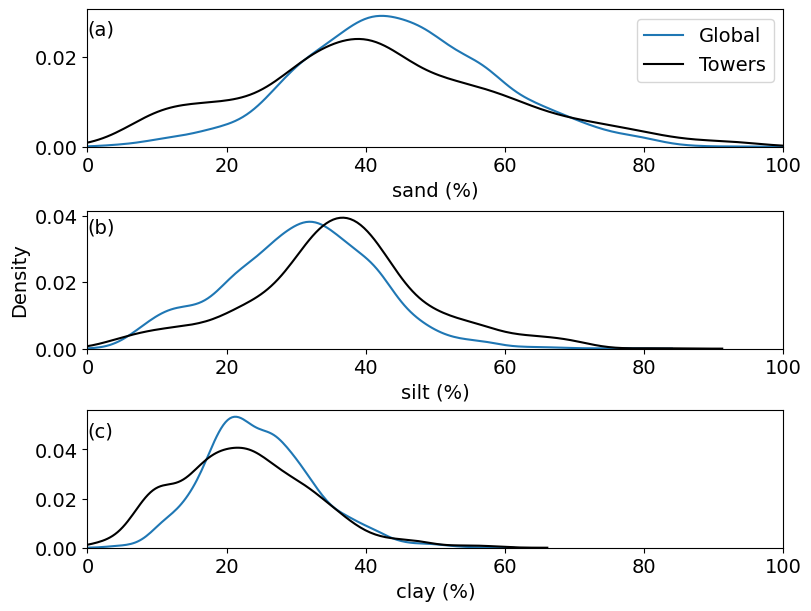

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8,6),layout='constrained')
sns.kdeplot(ax=axs[0],data=r,x='sand',label='Global')
sns.kdeplot(ax=axs[0],data=a,x='sand',color='k',label='Towers')
axs[0].set(xlabel="sand (%)", ylabel="",xlim=([0,100]))
axs[0].legend()
axs[0].text(0,.025,"(a)")

sns.kdeplot(ax=axs[1],data=r,x='silt')
sns.kdeplot(ax=axs[1],data=a,x='silt',color='k')
axs[1].set(xlabel="silt (%)", ylabel="Density",xlim=([0,100]))
axs[1].text(0,.035,"(b)")

sns.kdeplot(ax=axs[2],data=r,x='clay')
sns.kdeplot(ax=axs[2],data=a,x='clay',color='k')
axs[2].set(xlabel="clay (%)", ylabel="",xlim=([0,100]))
axs[2].text(0,.045,"(c)")

#Figure 5:
KDEs of soil quality compared to dataset pixels that contain eddy covariance towers

Text(8.8, 0.4, '(d)')

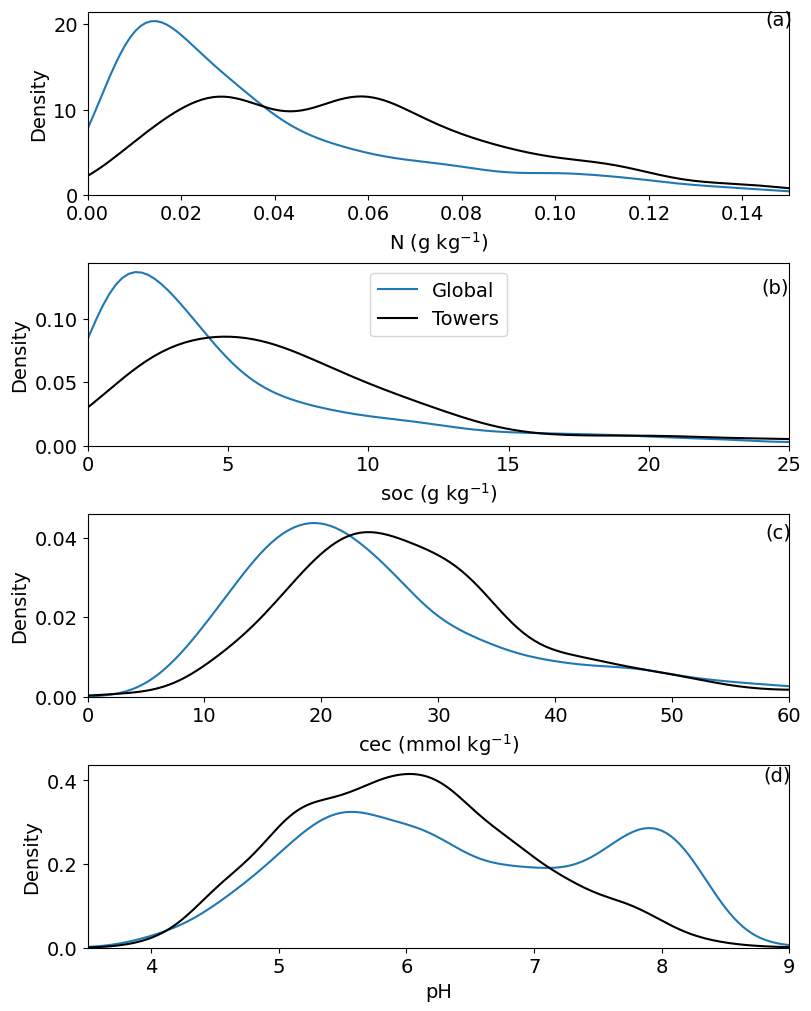

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(8,10),layout='constrained')
sns.kdeplot(ax=axs[0],data=r,x='N')
sns.kdeplot(ax=axs[0],data=a,x='N',color='k')
axs[0].set(xlabel="N (g kg$^{-1}$)", ylabel="Density",xlim=([0,0.15]))
axs[0].text(0.145,20,"(a)")

sns.kdeplot(ax=axs[1],data=r,x='soc',label='Global')
sns.kdeplot(ax=axs[1],data=a,x='soc',color='k',label='Towers')
axs[1].set(xlabel="soc (g kg$^{-1}$)", ylabel="Density",xlim=([0,25]))
axs[1].text(24,.12,"(b)")
axs[1].legend(loc='upper center')

sns.kdeplot(ax=axs[2],data=r,x='cec')
sns.kdeplot(ax=axs[2],data=a,x='cec',color='k')
axs[2].set(xlabel="cec (mmol kg$^{-1}$)", ylabel="Density",xlim=([0,60]))
axs[2].text(58,.04,"(c)")

sns.kdeplot(ax=axs[3],data=r,x='pH')
sns.kdeplot(ax=axs[3],data=a,x='pH',color='k')
axs[3].set(xlabel="pH", ylabel="Density",xlim=([3.5,9]))
axs[3].text(8.8,.4,"(d)")

#Figure 6:
A bar plot of soil and regolith depth

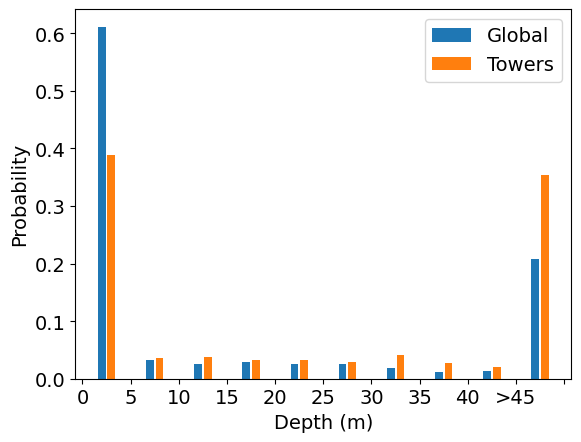

In [ ]:
rplot = rdepth.to_numpy()
tplot = tdepth.depth.to_numpy()

rplot = rplot[rplot!=255]
tplot = tplot[tplot!=255]
tplot = tplot[np.isnan(tplot)==0]

h = np.histogram(rplot)
h0,h1=h

t = np.histogram(tplot)
t0,t1=t

plt.bar(h1[0:10]+2,h[0]/sum(h[0]),label='Global')
plt.bar(t1[0:10]+3,t[0]/sum(t[0]),label='Towers')
plt.xlabel('Depth (m)')
plt.ylabel('Probability')
plt.legend()
plt.xticks([0,5,10,15,20,25,30,35,40,45,50], ['0','5','10','15','20','25','30','35','40','>45','']);

In [ ]:
print(np.mean(rplot))
print(np.mean(tplot))

14.816685801760428
24.030578512396694


Simple t-tests for differences between tower locations and global climate, elevation, and soil samples.

In [ ]:
from scipy import stats

alpha = .05/13 #Bonferroni correction
print('alpha:', alpha)

t_stat, p_MAT = stats.ttest_ind(r.dropna()['MAT_ds'], a.dropna()['MAT_ds'])
print('MAT:', p_MAT)

t_stat, p_MAP = stats.ttest_ind(r.dropna()['MAP_ds'], a.dropna()['MAP_ds'])
print('MAP:', p_MAP)

t_stat, p_srad = stats.ttest_ind(r.dropna()['SRAD_ds'], a.dropna()['SRAD_ds'])
print('SRAD:', p_srad)

t_stat, p_elev = stats.ttest_ind(r.dropna()['Elevation_ds'], a.dropna()['Elevation_ds'])
print('elevation:', p_elev)

t_stat, p_clay = stats.ttest_ind(r.dropna()['clay'], a.dropna()['clay'])
print('clay:', p_clay)

t_stat, p_sand = stats.ttest_ind(r.dropna()['sand'], a.dropna()['sand'])
print('sand:', p_sand)

t_stat, p_silt = stats.ttest_ind(r.dropna()['silt'], a.dropna()['silt'])
print('silt:', p_silt)

t_stat, p_bdod = stats.ttest_ind(r.dropna()['bdod'], a.dropna()['bdod'])
print('bdod:', p_bdod)

t_stat, p_cec = stats.ttest_ind(r.dropna()['cec'], a.dropna()['cec'])
print('cec:', p_cec)

t_stat, p_pH = stats.ttest_ind(r.dropna()['pH'], a.dropna()['pH'])
print('pH:', p_pH)

t_stat, p_N = stats.ttest_ind(r.dropna()['N'], a.dropna()['N'])
print('N:', p_N)

t_stat, p_soc = stats.ttest_ind(r.dropna()['soc'], a.dropna()['soc'])
print('soc:', p_soc)

t_stat, p_soildepth = stats.ttest_ind(rplot, tplot)
print('soildepth:', p_soildepth)
print(np.mean(rplot),np.std(rplot))
print(np.mean(tplot),np.std(tplot))

alpha: 0.0038461538461538464
MAT: 4.260127871813577e-10
MAP: 2.098472685530701e-05
SRAD: 8.317254716492318e-14
elevation: 3.1249001190239725e-05
clay: 5.968969506804131e-05
sand: 1.397227394149988e-16
silt: 9.61018367463897e-44
bdod: 0.6700940747651407
cec: 0.0002313147317561226
pH: 1.0599068652130008e-18
N: 1.6708988063885365e-27
soc: 5.581630356369087e-15
soildepth: 2.228030804228418e-37
14.816685801760428 19.966439432132898
24.030578512396694 21.642968216467963
